<a href="https://colab.research.google.com/github/will-hill/Yelp_NLP/blob/master/3.Basic_Keras_DL_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Keras Deep Learning NLP
inspired from 
* https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras
* https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff


### Review File
* 534,7475,638 bytes
* 6,685,900 reviews/lines

In [55]:
!nproc
!free -g
!nvidia-smi

32
              total        used        free      shared  buff/cache   available
Mem:            125          30          55           0          40          94
Swap:             7           0           7
Sun Aug  4 03:58:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   51C    P0    30W / 250W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                         

### Will's Setup Code
I created a couple subdirectories in my Google Drive

In [1]:
# LAB
REVIEW_FILE_JSON = 'review.json' 
# COLAB
# REVIEW_FILE_JSON = '/content/drive/My Drive/colab/yelp_nlp/review.json'

### Colab Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


80 seconds

In [6]:
%%time
REVIEWS_TO_INGEST = 6685900
data_list = list()
columns = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

# inspired by https://thedatafrog.com/text-mining-pandas-yelp/
with open(REVIEW_FILE) as reviews:
    import json
    for i, line in enumerate(reviews):

        if i == REVIEWS_TO_INGEST:
            break

            # convert json line to di t
        data = json.loads(line)
        data_list.append([data['review_id'],
                          data['user_id'],
                          data['business_id'],
                          data['stars'],
                          data['useful'],
                          data['funny'],
                          data['cool'],
                          data['text'],
                          data['date']])

reviews.close()
del reviews, i, line, data, REVIEWS_TO_INGEST, json
###
import pandas
df = pandas.DataFrame(data_list, columns=columns)
del data_list, columns, pandas

%who

REVIEW_FILE	 df	 
CPU times: user 1min 10s, sys: 12.6 s, total: 1min 23s
Wall time: 1min 19s


2 minutes, 10 seconds

In [8]:
# LAB   ~ 1:41
%time df.to_csv('reviews.csv', index=False, encoding='UTF-8')
# COLAB ~ 2:08 
# %time df.to_csv('/content/drive/My Drive/colab/yelp_nlp/reviews.csv', index=False, encoding='UTF-8')

CPU times: user 1min 35s, sys: 5.84 s, total: 1min 41s
Wall time: 1min 41s


In [ ]:
# LAB
df.to_hdf('reviews.h5', key='df', mode='w')
# COLAB
# df.to_hdf('/content/drive/My Drive/colab/yelp_nlp/reviews.h5', key='df', mode='w')

### Joanna Setup Code

In [0]:
from google.colab import drive #python code
drive.mount('/content/drive') # python code <- follow the resulting directions
!ln -s drive/My\ Drive data # bash command
!ls # you should "see" drive directory now.
hd5_path='data/reviews.h5'
#!pip install numpy==1.15.4

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
data  drive  sample_data


## Regression: Number of Stars

50 seconds

In [2]:
%%time
REVIEW_FILE_CSV = 'reviews.csv'
import pandas as pd
df = pd.read_csv(REVIEW_FILE_CSV)
del pd, REVIEW_FILE_CSV

CPU times: user 45.7 s, sys: 6.73 s, total: 52.5 s
Wall time: 48.5 s


In [3]:
df_all = df

In [44]:
df = df_all.head(50000)

### create word index

In [45]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
del Tokenizer

### convert words to indices

In [46]:
X = tokenizer.texts_to_sequences(df.text.values)
del tokenizer

### add zeroes so all texts are same length

In [47]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X)
del pad_sequences

### prepare target

In [48]:
# Normalize Y to be between 0 and 1
Y = df.stars / max(df.stars)

### split data

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

del train_test_split

(33500, 1003) (33500,)
(16500, 1003) (16500,)


In [50]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

OUTPUT_DIM = 8 #128
LSTM_OUT = 8 #196

model = Sequential()

# https://keras.io/layers/embeddings/
# keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)
model.add(Embedding(VOCAB_SIZE, 
                    OUTPUT_DIM, 
                    mask_zero=True,
                    input_length = X_train.shape[1]))

# model.add(SpatialDropout1D(0.2))

# model.add(LSTM(LSTM_OUT, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(LSTM_OUT, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(LSTM_OUT, 
               dropout=0.0, 
               recurrent_dropout=0.0)
         )


model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1003, 8)           481904    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 482,457
Trainable params: 482,457
Non-trainable params: 0
_________________________________________________________________
None


---
1000 reviews  
1 epoch = 50 seconds  
5 epochs = 2:55

---
50000 reviews

In [ ]:
%%time
batch_size = 256
epochs = 10
history = model.fit(X_train, Y_train, validation_split=0.333, epochs = epochs, batch_size=batch_size, verbose = 2)

Train on 22344 samples, validate on 11156 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], '.-')
plt.plot(history.history['val_acc'], '.-')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')

plt.title('training')
plt.xlabel('epoch')
plt.legend(['acc','val_acc','loss','val_loss'], loc='best')

del plt

In [38]:
loss, mae, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)

In [39]:
print(loss) #mse
print(mae)
print(acc)

0.06315215825582995
0.2078539715752457
0.43454545375072595


In [40]:
y_pred= model.predict(X_test)

In [41]:
y_pred[0:5]

array([[0.7637736 ],
       [0.73383063],
       [0.68500835],
       [0.8466127 ],
       [0.7131006 ]], dtype=float32)

In [42]:
Y_test[0:5]

6252    0.6
4684    0.6
1731    0.4
4742    1.0
4521    0.6
Name: stars, dtype: float64

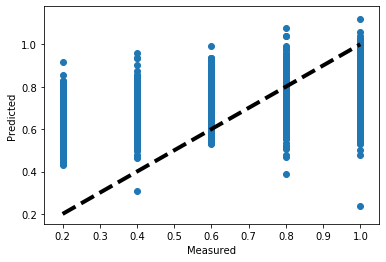

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(Y_test, y_pred)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()